# Pruning streagy
由於我們的模型可能會因為參數量過大，而導致速度以及使用率上有些問題，因此可以使用keras中的剪枝功能去完成。

同樣的在一開始我們先導入我們的資料集。在一開始模型如果有使用資料增強，再做pruning時也必須使用，這樣才不會導致輸入的資料範圍有變動。

In [1]:
import qkeras.utils
import tensorflow_model_optimization as tfmot
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import clone_model
from tensorflow.keras import optimizers
import qkeras
from qkeras.utils import load_qmodel
import warnings
warnings.filterwarnings('ignore')
import json
import pprint
import numpy as np
import six
import tempfile


from qkeras.autoqkeras import *
from qkeras import *
from qkeras.utils import model_quantize
from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings
import tensorflow_addons as tfa


print("using tensorflow", tf.__version__)
import numpy as np
import urllib.request
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# X_train = tf.image.resize(X_train, (16,16)) 
# X_test = tf.image.resize(X_test, (16,16)) 
mean = np.mean(X_train, axis=(0, 1, 2, 3))
std = np.std(X_train, axis=(0, 1, 2, 3))

X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)

y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).

datagen.fit(X_train)

# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')



2025-08-01 16:59:55.210466: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 16:59:55.287934: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 16:59:55.610854: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 16:59:55.611961: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-01 16:59:56.531957: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

using tensorflow 2.12.0


在一開始我們先查看模型參數的稀疏度。

In [2]:
def print_model_sparsity(model):
    total_params = 0
    zero_params = 0
    for layer in model.layers:
        for weight in layer.get_weights():
            total_params += weight.size
            zero_params += np.sum(weight == 0)
    sparsity = zero_params / total_params if total_params > 0 else 0
    print(f"Total params: {total_params}")
    print(f"Zero params: {zero_params}")
    print(f"Global sparsity: {sparsity:.2%}")

# 使用範例


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


2025-07-27 02:43:23.958213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-27 02:43:24.001338: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Total params: 158394
Zero params: 0
Global sparsity: 0.00%


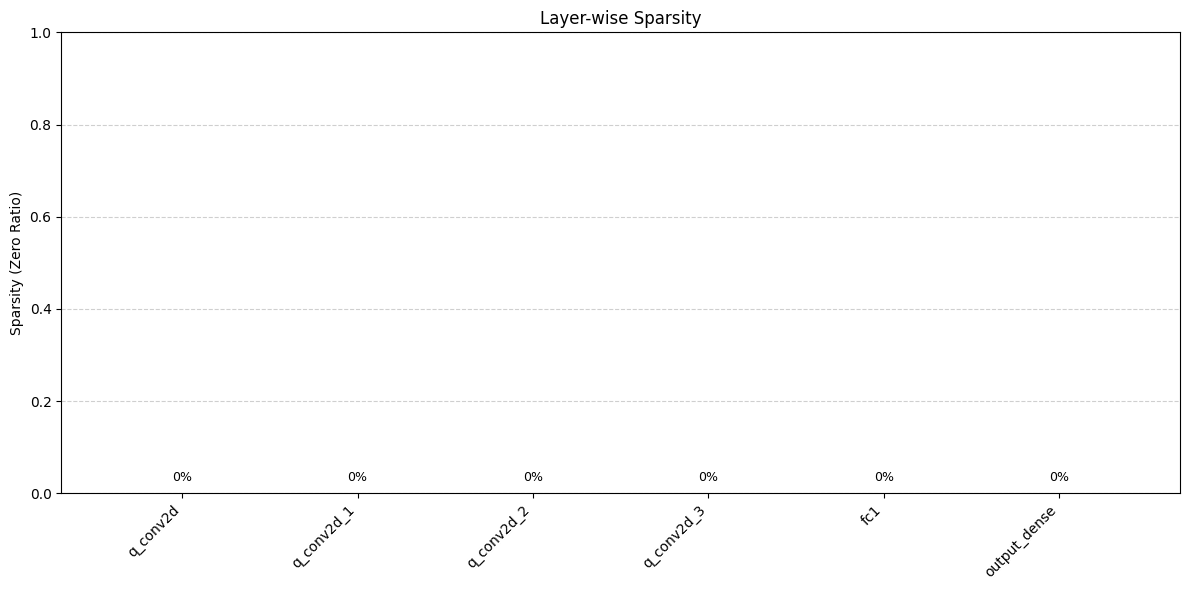

In [3]:
!pip install pydot
q_model = qkeras.utils.load_qmodel("model_cpu.h5")
print_model_sparsity(q_model)  # 換成你自己的模型變數名
# from tensorflow.keras.utils import plot_model
# plot_model(q_model, to_file='model.png', show_shapes=True, show_layer_names=True)
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D

layer_names = []
sparsities = []

for layer in q_model.layers:
    # 只分析有 weights 的層（像是 Dense、Conv2D）
    if hasattr(layer, 'weights') and layer.get_weights():
        weights = layer.get_weights()[0]  # 只看 kernel，不含 bias
        zero_count = np.sum(weights == 0)
        total_count = weights.size
        sparsity = zero_count / total_count
        layer_names.append(layer.name)
        sparsities.append(sparsity)

# 畫圖
plt.figure(figsize=(12, 6))
bars = plt.bar(layer_names, sparsities, color='cornflowerblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Sparsity (Zero Ratio)")
plt.title("Layer-wise Sparsity")
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 顯示數值
for bar, spar in zip(bars, sparsities):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{spar:.0%}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

在這邊可以看到我們模型參數稀疏度都是0。

In [4]:
q_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 q_conv2d (QConv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 q_conv2d_1 (QConv2D)        (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 q_conv2d_2 (QConv2D)        (None, 8, 8, 32)          4640  

# 剪枝策略
在本節中，我們定義了剪枝策略。由於剪枝對模型的準確度可能造成較大影響，因此通常不會一次性大量剪枝，而是透過逐步增加稀疏度的方式，讓模型逐漸適應參數被剪枝後的狀態。若一次剪得太多，可能會導致模型的學習速率與準確度大幅下降。

為了避免這種情況，我們採用了 Polynomial Decay 的方式來平滑地調整稀疏度。此次實驗中，我們將稀疏度從 0% 緩慢提升至 87%，並在 120 個 epoch 內進行，以降低對模型表現的負面影響。

In [ ]:


print_model_sparsity(q_model)  # 換成你自己的模型變數名

# STEP 2: Pruning config（這裡是逐步從 0 開始到 50% sparsity）
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.87,
        begin_step=0,
        end_step=np.ceil(len(X_train) / 64).astype(np.int32) * 120  # 120 個 epoch
    )
}

# STEP 3: 包裝模型（prune 會自動包裝 layer）
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(q_model, **pruning_params)

# STEP 4: Compile
pruned_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),  # 根據你的任務調整
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

# STEP 5: Callbacks（包含 pruning summary、early stop、checkpoint）
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='./prune_logs'),
    ModelCheckpoint('best_pruned_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
]

# STEP 6: 訓練 pruned 模型
history = pruned_model.fit(
    datagen.flow(X_train, y_train,
                                     batch_size=64),
    validation_data=(X_test, y_test),
    epochs=120,
    batch_size=64,
    callbacks=callbacks
)

# STEP 7: Strip 掉 pruning wrapper，轉成普通模型（部署或測試用）
final_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

# 儲存最終乾淨模型
final_model.save('final_stripped_pruned_model.h5')


Total params: 158394
Zero params: 0
Global sparsity: 0.00%
Epoch 1/120


2025-07-27 02:43:25.685402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 16s 18ms/step - loss: 0.7146 - accuracy: 0.7495 - val_loss: 0.8697 - val_accuracy: 0.7096
Epoch 2/120
782/782 [==============================] - 14s 18ms/step - loss: 0.7207 - accuracy: 0.7488 - val_loss: 0.7766 - val_accuracy: 0.7291
Epoch 3/120
782/782 [==============================] - 14s 18ms/step - loss: 0.7216 - accuracy: 0.7485 - val_loss: 0.7537 - val_accuracy: 0.7439
Epoch 4/120
782/782 [==============================] - 15s 19ms/step - loss: 0.7140 - accuracy: 0.7506 - val_loss: 0.7982 - val_accuracy: 0.7288
Epoch 5/120
782/782 [==============================] - 15s 19ms/step - loss: 0.7207 - accuracy: 0.7483 - val_loss: 0.7900 - val_accuracy: 0.7293
Epoch 6/120
782/782 [==============================] - 15s 19ms/step - loss: 0.7151 - accuracy: 0.7504 - val_loss: 0.7814 - val_accuracy: 0.7315
Epoch 7/120
782/782 [==============================] - 15s 19ms/step - loss: 0.7185 - accuracy: 0.7503 - val_loss: 0.8075 - val_accuracy: 0.72

In [6]:
final_model.summary()


print_model_sparsity(final_model)  # 換成你自己的模型變數名

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 q_conv2d (QConv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 q_conv2d_1 (QConv2D)        (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 q_conv2d_2 (QConv2D)        (None, 8, 8, 32)          4640  

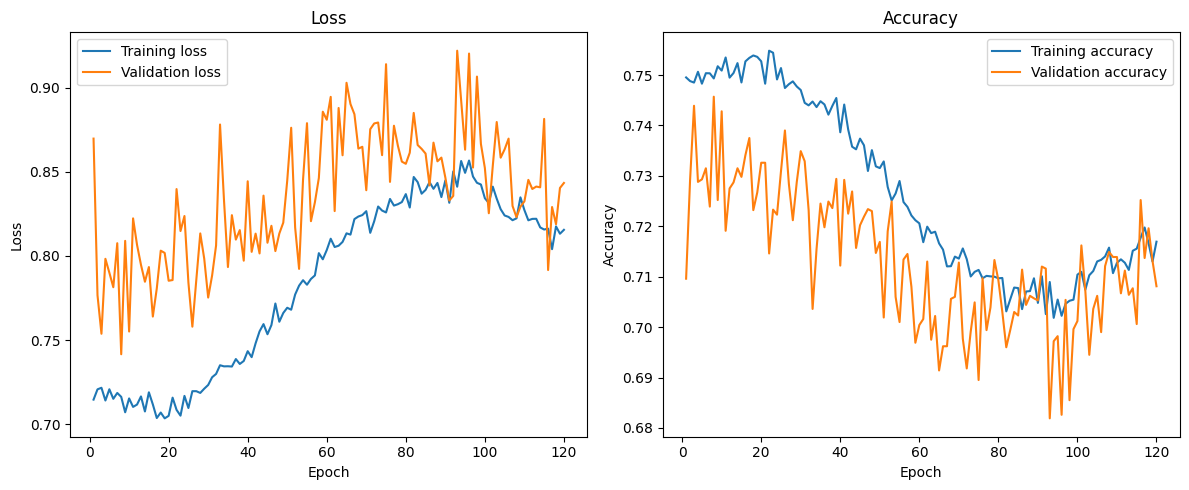

In [7]:
import matplotlib.pyplot as plt


# 把資料從 history 取出
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')
accuracy = history_dict.get('accuracy') or history_dict.get('acc')
val_accuracy = history_dict.get('val_accuracy') or history_dict.get('val_acc')

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
if accuracy:
    plt.plot(epochs, accuracy, label='Training accuracy')
if val_accuracy:
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

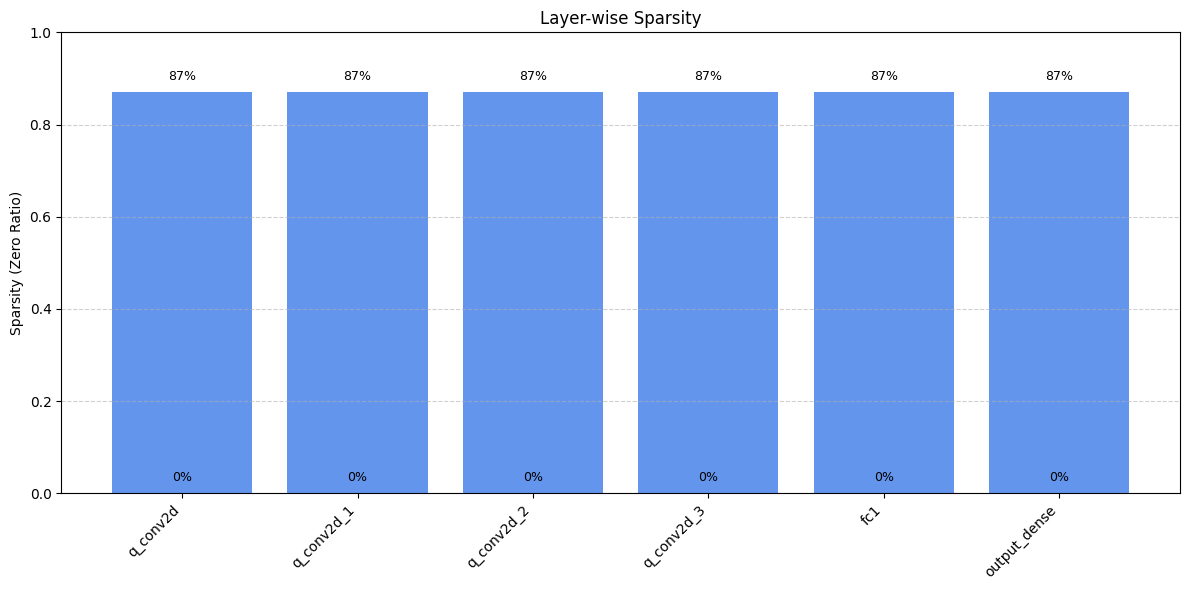

In [8]:
for layer in final_model.layers:
    # 只分析有 weights 的層（像是 Dense、Conv2D）
    if hasattr(layer, 'weights') and layer.get_weights():
        weights = layer.get_weights()[0]  # 只看 kernel，不含 bias
        zero_count = np.sum(weights == 0)
        total_count = weights.size
        sparsity = zero_count / total_count
        layer_names.append(layer.name)
        sparsities.append(sparsity)

# 畫圖
plt.figure(figsize=(12, 6))
bars = plt.bar(layer_names, sparsities, color='cornflowerblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Sparsity (Zero Ratio)")
plt.title("Layer-wise Sparsity")
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 顯示數值
for bar, spar in zip(bars, sparsities):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{spar:.0%}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()